# Straight step index fibers

In [1]:
import pyMMF
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(18,9))
rc('text', usetex=True)
from IPython.display import display, Math

## 1. Fiber parameters

In [2]:
## Parameters
NA = 0.15
radius = 10. # in microns
areaSize = 3.5*radius # calculate the field on an area larger than the diameter of the fiber
npoints = 2**8 # resolution of the window
n1 = 1.45
wl = 0.6328 # wavelength in microns

## 2. Compute the mode with three different solvers

### 2.1 Index profile

In [3]:
# Create the fiber object
profile = pyMMF.IndexProfile(npoints = npoints, areaSize = areaSize)

# Initialize the index profile
profile.initStepIndex(n1=n1,a=radius,NA=NA)

# Instantiate the solver
solver = pyMMF.propagationModeSolver()

# Set the profile to the solver
solver.setIndexProfile(profile)

# Set the wavelength
solver.setWL(wl)

# Estimate the number of modes for a graded index fiber
Nmodes_estim = pyMMF.estimateNumModesSI(wl,radius,NA,pola=1)

print(f"Estimated number of modes using the V number = {Nmodes_estim}")

2024-07-16 12:52:07,712 - pyMMF.core [DEBUG  ]  Debug mode ON.


<function IndexProfile.initStepIndex.<locals>.radialFunc at 0x7307779b2a20>
Estimated number of modes using the V number = 56


### 2.2 Semi-analytical solution: `SI` solver

In [4]:
modes_semianalytical = solver.solve(mode = 'SI', curvature = None)

2024-07-16 12:52:07,718 - pyMMF.solv [INFO   ]  Finding the propagation constant of step index fiber by numerically solving the dispersion relation.
2024-07-16 12:52:08,413 - pyMMF.solv [INFO   ]  Found 59 modes in 0.69 seconds.
2024-07-16 12:52:08,413 - pyMMF.solv [INFO   ]  Finding analytical LP mode profiles associated to the propagation constants.
2024-07-16 12:52:11,905 - pyMMF.solv [INFO   ]  Found 59 LP mode profiles in 0.1 minutes.
2024-07-16 12:52:11,906 - pyMMF.core [DEBUG  ]  Mode data stored in memory.


### 2.3 Solving the 2d Eigenvalue solver: `eig` solver (slow) 
See the [tutorial](https://www.wavefrontshaping.net/post/id/3) 
for more information.

In [5]:
modes_eig = solver.solve(nmodesMax=Nmodes_estim+10,
                         boundary = 'close', 
                         mode = 'eig', 
                         curvature = None, 
                         propag_only=True)

2024-07-16 12:52:11,913 - pyMMF.solv [INFO   ]  Solving the spatial eigenvalue problem for mode finding.
2024-07-16 12:52:11,914 - pyMMF.solv [INFO   ]  Use close boundary condition.
2024-07-16 12:54:15,920 - pyMMF.solv [INFO   ]  Solver found 59 modes is 124.01 seconds.
2024-07-16 12:54:15,927 - pyMMF.core [DEBUG  ]  Mode data stored in memory.


### 2.4 Finding the 1d radial solution: `radial` solver (fast, more precise)
See the [tutorial](https://www.wavefrontshaping.net/post/id/66)
and the article [Learning and avoiding disorder in multimode fibers](https://arxiv.org/abs/2010.14813) 
for more information.

In [6]:
modes_radial = solver.solve(mode = 'radial',  
                         propag_only=True,
                         N_beta_coarse = int(1e3))

2024-07-16 12:54:15,955 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=0
2024-07-16 12:54:15,956 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2024-07-16 12:54:15,961 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 2
2024-07-16 12:54:15,964 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 3
2024-07-16 12:54:15,968 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 4
2024-07-16 12:54:15,972 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 5
2024-07-16 12:54:15,981 - pyMMF.solv [INFO   ]  Found 4 radial mode(s) for m=1
2024-07-16 12:54:15,981 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2024-07-16 12:54:15,987 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 2
2024-07-16 12:54:15,992 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 3
2024-07-16 12:54:15,997 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 4
2024-07-16 12:54:16,010

## 3. Comparing results

### 3.1 Dispersion

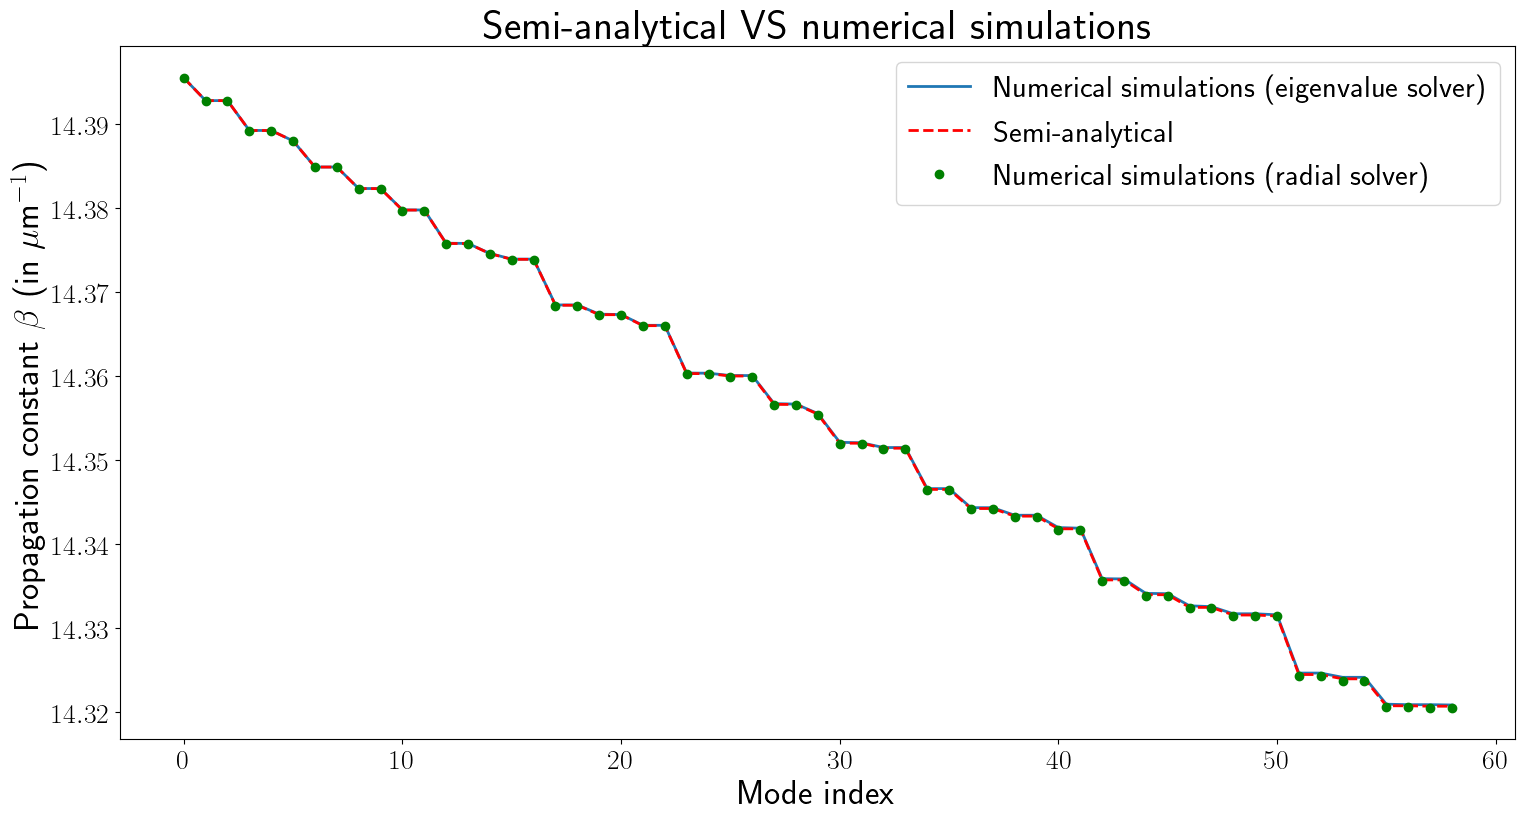

In [17]:
# Sort the modes
modes_eig.sort()
modes_semianalytical.sort()
modes_radial.sort()

modes = {}
modes['SA'] = {'betas':np.array(modes_semianalytical.betas),'profiles':modes_semianalytical.profiles}
modes['eig'] = {'betas':np.array(modes_eig.betas),'profiles':modes_eig.profiles}
modes['radial'] = {'betas':np.array(modes_radial.betas),'profiles':modes_radial.profiles}


plt.figure(); 
plt.plot(np.real(modes_eig.betas),
         label='Numerical simulations (eigenvalue solver)',
         linewidth=2.)
plt.plot(np.real(modes_semianalytical.betas),
         'r--',
         label='Semi-analytical',
         linewidth=2.)
plt.plot(np.real(modes_radial.betas),
         'go',
         label='Numerical simulations (radial solver)',
         linewidth=2.)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title(r'Semi-analytical VS numerical simulations' ,fontsize = 30)
plt.ylabel(r'Propagation constant $\beta$ (in $\mu$m$^{-1}$)', fontsize = 25)
plt.xlabel(r'Mode index', fontsize = 25)
plt.legend(fontsize = 22,loc='upper right')
plt.show()

### 2.2 Comparing numerical solutions to LP modes

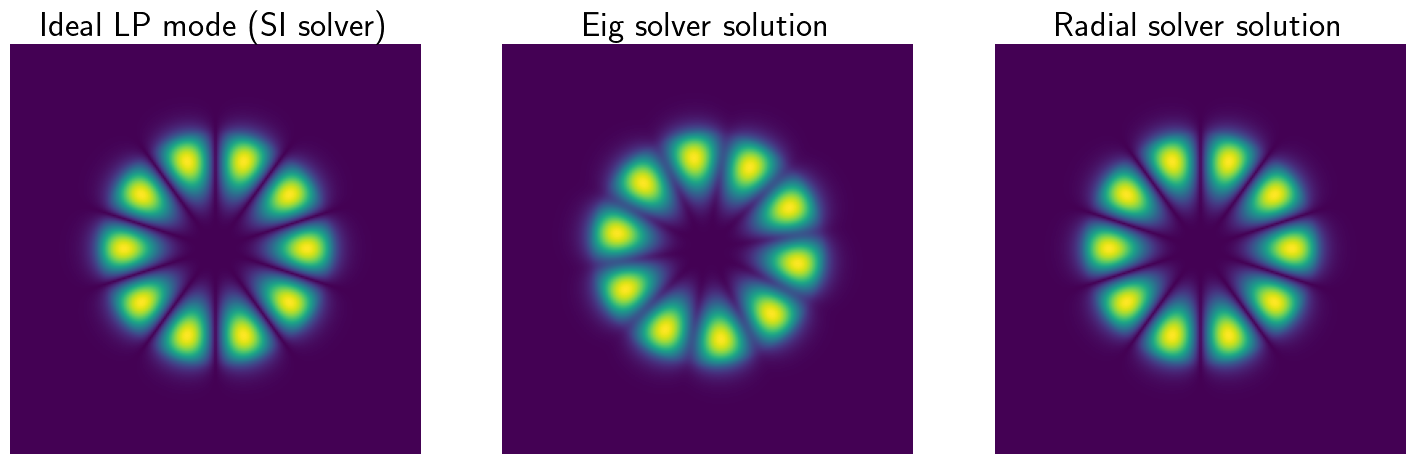

In [16]:
imode = 15
plt.figure()
plt.subplot(131)
plt.imshow(np.abs(modes['SA']['profiles'][imode].reshape([npoints]*2)))
plt.gca().set_title("Ideal LP mode (SI solver)",fontsize=25)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.abs(modes['eig']['profiles'][imode].reshape([npoints]*2)))
plt.gca().set_title("Eig solver solution",fontsize=25)
plt.axis('off')
plt.subplot(133)
plt.imshow(np.abs(modes['radial']['profiles'][imode].reshape([npoints]*2)))
plt.gca().set_title("Radial solver solution",fontsize=25)
plt.axis('off');